## What is Reparameterisation?

* Expressing the model in terms of new variables defined by a bijective transformation of the original variables.
* For example: One such reparameterization technique is Non-centering.
    * Consider: z ~ $N(\mu, \sigma)$ (centered parameterization)
    * Introducing z' ~ $N(0,1)$ 
    * Now, z = $\mu + \sigma z'$ (Non-centered parameterization)

## Why Reparameterisation?

* At times MCMC algorithms have trouble sampling from distributions. 
* One such example is Neal's funnel in which due to strong non-linear dependence between latent variables. 
* Non-centering the model removes this dependence, converting the funnel into a spherical Gaussian distribution.
* NealsFunnel(z, x)
    * $z ∼ N (0, 3)$ $\quad$
    * $x ∼ N (0, \exp(z/2))$

<div align = center>
<img width="600" alt="image" src="images/wnr/funnel_c.webp">
</div>

Thus, centering is not the solution to all sampling related problems.

In [1]:
## Slide not to be shown (imports)
import jax
import optuna
import numpyro
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax.scipy.optimize import minimize

rng_key = jax.random.PRNGKey(0) 
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam

In [2]:
## Slide not to be shown (Some functions)
def inference(model):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
    mcmc.run(rng_key, extra_fields=('potential_energy',))
    return mcmc.get_samples()

def scatterplt(samples):
    try:
        plt.scatter(samples['theta_decentered'], samples['mu'])
        plt.xlabel('theta_decentered')
    except:
        plt.scatter(samples['theta'], samples['mu'])
        plt.xlabel('theta')
    plt.ylabel('mu')
    plt.show()

* Lets' see an example to find out why!

In [3]:
samples_normal = jax.random.normal(rng_key, shape=(10000,)) + 3  ## samples from a standard normal

def model():
    mu = numpyro.sample('mu', dist.Normal(5, 1))                  ## mu ~ N(5,1)
    theta = numpyro.sample('theta', dist.Normal(mu, 2))           ## theta ~ N(mu,2)
    numpyro.sample('obs', dist.Normal(theta, 1), obs=samples_normal)     ## P(y|theta) ~ N(theta,1)

sample: 100%|██████████| 1500/1500 [00:05<00:00, 285.49it/s, 427 steps of size 1.29e-02. acc. prob=0.91]


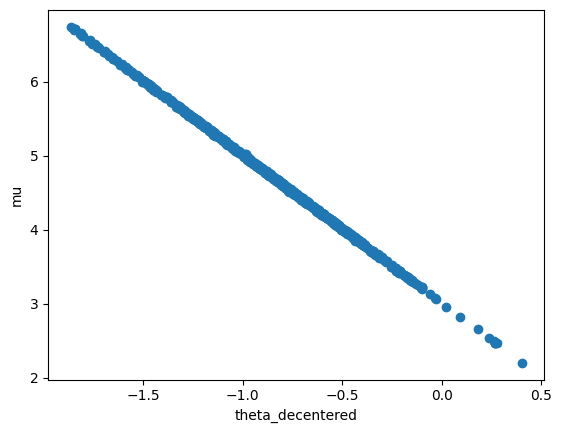

In [4]:
ncp_model = reparam(model, config={'theta': LocScaleReparam(0)})
samples_ncp = inference(ncp_model)
scatterplt(samples_ncp)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 918.19it/s, 7 steps of size 7.40e-01. acc. prob=0.93] 


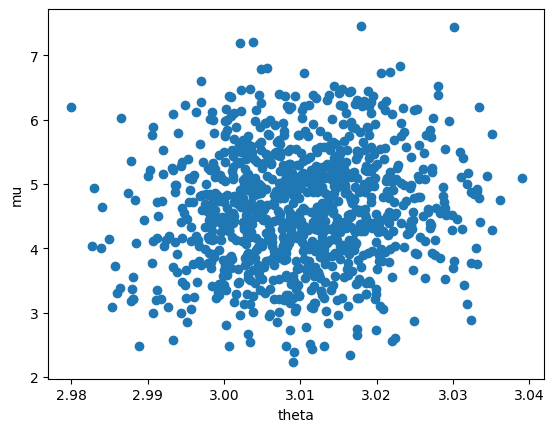

In [5]:
ncp_model = reparam(model, config={'theta': LocScaleReparam(1)})
samples_ncp = inference(ncp_model)
scatterplt(samples_ncp)

* From the above experiment it is evident that the we don't get the best results in non-centered parameterisation rather the best centeredness varies from model to model based on parameters.

## Centeredness vs Non-centeredness

* The best parameterization for a given model may lie somewhere between centered and non centered representation.
* Existing solutions: 
    * Variationally Inferred Parameterization[1]  
    * NeuTra-lizing Bad Geometry in HMC[2]

## Problems with existing solutions

* Requires separate pre-processing steps apart from the regular warmup and sampling steps which increases the computation cost.
* Need to tune the hyperparameters for the existing solutions to get good results

## Proposed Solution

* Finding the optimal centeredness during the succesive windows of warmup.
* Loss function for finding centeredness should be such that it takes the parameterized distribution as close as possible to Normal distribution.


## Warmup Phase

* Used for adaptation of inverse mass matrix ($M^{-1}$) and time step size ($\Delta t$).
* Consist of three stages:
<img width="1000" alt="image" src="images/wnr/warmup-epochs.png">
    
    * Initial buffer (I): Time step adaptation ($\Delta t$)
    * Window buffer (II): Both Time step ($\Delta t$) & Inverse mass matrix adaptation ($M^{-1}$)
    * Term buffer (III): Final Time step adaptation ($\Delta t$)

## Modified Warmup Phase

* Used for adaptation of inverse mass matrix ($M^{-1}$), time step size ($\Delta t$) and *centeredness ($c$)*.
* Initial buffer and Term buffer remains the same.
* Using the samples obtained after each window buffer, optimize the centeredness ($c$) so as to reduce the distance between the present reparameterized distribution and an independent normal distribution.
* For each succesive window, reparameterize the model based on the optimal centeredness obtained and repeat the step for finding optimal centeredness.

## Loss Function

* $\Theta^{SXN}$ $\to$ matrix of draws
* $\Phi^{(c)}$ $\to$ bijective family of reparameterisation (maps $P$ to $P_{c}$ and $\Theta$ to $\Theta_{c})$


* $\log p_{c}(\theta^{(c)})$ = $\log p\ (inv\ \Phi^{(c)})$ + $\log |\nabla_{\theta} \Phi^{(c}|$
* $Q^{c}$~$N(mean(\Theta_{c}), diag var(\Theta_{c}))$
* $\Phi^{(c^{*})} =\ argmin_{\Phi^{(c)}}KL(P^{(c)}||Q^{(c)})$

## Experimentation

* Initial experiments done on Eight School 's model.

In [6]:
J = 8
y = jnp.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = jnp.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [7]:
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(2, 5))                 # mu ~ N(2,5)
    tau = numpyro.sample('tau', dist.HalfCauchy(5))              # tau ~ HalfCauchy(5)
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))    # theta_i ~ N(mu,tau)
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)  # P(y|theta_i) ~ N(theta_i, sigma)

* On post warmup samples

In [8]:
# Sampling
nuts_kernel = NUTS(eight_schools)
warmup = MCMC(nuts_kernel, num_warmup=1000, num_samples=0)    # Collecting all warmup samples           
warmup.warmup(rng_key, J, sigma, y=y, collect_warmup=True)
samples = warmup.get_samples()

warmup: 100%|██████████| 1000/1000 [00:01<00:00, 650.18it/s, 31 steps of size 1.67e-01. acc. prob=0.79]


* Using the following continuous reparameterization family (from Variationally Inferred Parameterization (VIP)) :
    * For each $z_{i}$ ~ $N(z_{i}|\mu_{i}, \sigma_{i})$
    * Define $z'_{i}$ ~ $N(\lambda_{i} \mu_{i}, \sigma^{\lambda_{i}}) $
    * Now, $z_{i}$ = $\mu_{i} + \sigma_{i}^{1-\lambda_{i}}(z'_{i}-\lambda_{i}\mu_{i})$

In [9]:
# For reparameterizing the samples and for creating the mulivariate normal distribution
def reparameterize_samples_dist(samples, c):
    param_samples = samples['theta'].T
    param_mean = samples['mu']
    param_std = samples['tau']

    new_param_samples = param_mean * c + (param_samples - param_mean) * param_std ** (c - 1)
    
    theta_mu = jnp.mean(new_param_samples, axis=1)
    theta_std = jnp.std(new_param_samples, axis=1)
    
    mvn = dist.MultivariateNormal(loc=theta_mu, covariance_matrix=jnp.diag(theta_std**2))
    
    return new_param_samples, mvn, theta_mu, theta_std

In [10]:
# For Computing the jacobian matrix for transformation
def log_jacobian(samples, c):
    sigma = samples['tau']
    logJ = jnp.sum(jnp.log(sigma) * (1 - c) * samples['theta'].shape[1])
    logJ /= len(sigma)
    return logJ

In [11]:
# Function for computing KL divergence
def kl_value(centeredness):
    centeredness = centeredness[0]
    reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, centeredness)
    jacobian_log = log_jacobian(samples, centeredness)
    kl = -mvn.log_prob(reparam_sample.T).mean() + jacobian_log    
    return kl

### Optimization

* Jax based BFGS Optimization

In [12]:
# jax based BFGS optimization
c_initial = jnp.array([0.1])
res = minimize(kl_value, c_initial, method='BFGS')

best_c_jax = res.x[0]
print(best_c_jax)

0.039444983


* Optuna based optimization

In [13]:
def kl_value_optuna(centeredness):
    reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, centeredness)
    jacobian_log = log_jacobian(samples, centeredness)
    kl = -mvn.log_prob(reparam_sample.T).mean() + jacobian_log    
    return kl

In [14]:
# Defining the function that needs to be minimized
def objective(trial):
    x = trial.suggest_float('x', 0, 1) 
    loss = kl_value_optuna(x)
    return loss

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
best_c_optuna = best_trial.params['x']

[I 2023-07-21 12:30:17,152] A new study created in memory with name: no-name-ce6ea8e4-5557-4576-b6d3-9b66b3f4e014
[I 2023-07-21 12:30:17,522] Trial 0 finished with value: 21.478862762451172 and parameters: {'x': 0.17584669682579634}. Best is trial 0 with value: 21.478862762451172.
[I 2023-07-21 12:30:17,528] Trial 1 finished with value: 24.09613037109375 and parameters: {'x': 0.7817069280810928}. Best is trial 0 with value: 21.478862762451172.
[I 2023-07-21 12:30:17,533] Trial 2 finished with value: 22.280963897705078 and parameters: {'x': 0.30662176874135927}. Best is trial 0 with value: 21.478862762451172.
[I 2023-07-21 12:30:17,544] Trial 3 finished with value: 24.22972297668457 and parameters: {'x': 0.8316834716343527}. Best is trial 0 with value: 21.478862762451172.
[I 2023-07-21 12:30:17,549] Trial 4 finished with value: 24.571487426757812 and parameters: {'x': 0.9536417862630372}. Best is trial 0 with value: 21.478862762451172.
[I 2023-07-21 12:30:17,558] Trial 5 finished with v

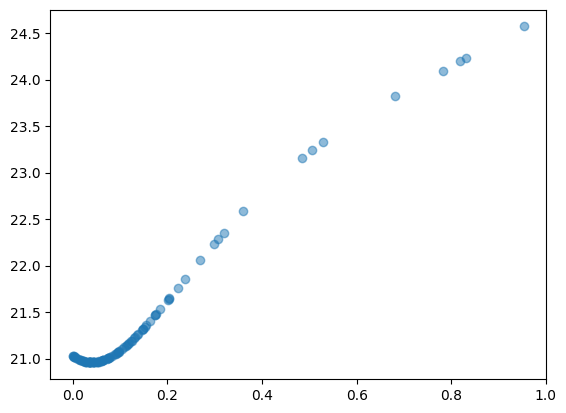

In [16]:
df_study = study.trials_dataframe()
plt.plot(df_study['params_x'], df_study['value'], 'o', alpha=0.5)
plt.show()

* Evident from above that Optuna keeps decreasing the search space after each iteration to get close to the best centeredness value.

In [17]:
# Function for creating the scatter plot
def scatterplt_2(samples, c):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes = axes.flatten()
    reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, c)
    reparam_sample = reparam_sample if reparam else samples['theta'].T
    axes[0].scatter(reparam_sample[0],jnp.log(samples['tau']))
    axes[0].set_xlabel('theta0_reparam')
    axes[0].set_ylabel('log_std')

    axes[1].scatter(samples['theta'].T[0],jnp.log(samples['tau']))
    axes[1].set_xlabel('theta0')

* Results obtained from initial experiments

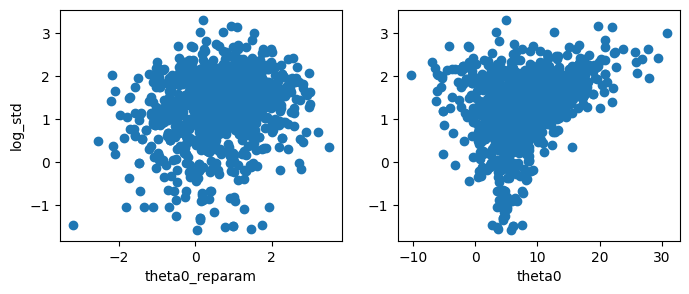

In [18]:
scatterplt_2(samples, c = best_c_jax)     ## Using the best centeredness computed

## Implementation

* Modified BlackJax sampler code to incorporate the proposed algorithm.
* Inference time up from 2 seconds to 20 seconds.
* To evaluate the results used a model whose true centeredness already known:

**Write the model**

## Results


<div style="display: flex; flex-direction: row; justify-content: space-between;">
<div>
    <img width="400" alt="image" src="images/wnr/true_calculated.png">
</div>
<div>    
<img width="400" alt="image" src="images/wnr/l2_norm_plot.png">
    </div>
</div>

<img width="500" alt="image" src="images/wnr/method_comparison.png">

* Lets' compare the sampling efficieny


\begin{array}{c} \hline
Parameter & ESS/ \nabla (vip) & ESS/ \nabla (our) \\ \hline
\mu & 9.27*10^{-4} & 5.54*10^{-4} \\
\tau & 4.22*10^{-5} & \textbf{$5.07*10^{-4}$} \\
\theta & 9.73*10^{-4} & \textbf{$1.66*10^{-3}$} \\ \hline
\end{array}


* Our ESS/ $\nabla$ results better then the ones produced by existing methods. 

## Future Work

* Changing the default window sizes.
* Trying different parameterization families.

## References
[1] M.I.Gorinova,D.Moore,andM.D.Hoffman,“Automaticreparameterisation of probabilistic programs,” 2019.

[2] M.Hoffman,P.Sountsov,etal.,“Neutra-lizing bad geometry in hamiltonian monte carlo using neural transport,” 2019.